In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix


train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test_noLabel.csv')
train_data.head()

c:\python35\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


,ID,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Label
0,0,37,Travel_Rarely,Research & Development,1,4,Life Sciences,77,1,Male,...,80,1,7,2,4,7,5,0,7,0
1,1,54,Travel_Frequently,Research & Development,1,4,Life Sciences,1245,4,Female,...,80,1,33,2,1,5,4,1,4,0
2,2,34,Travel_Frequently,Research & Development,7,3,Life Sciences,147,1,Male,...,80,0,9,3,3,9,7,0,6,1
3,3,39,Travel_Rarely,Research & Development,1,1,Life Sciences,1026,4,Female,...,80,1,21,3,3,21,6,11,8,0
4,4,28,Travel_Frequently,Research & Development,1,3,Medical,1111,1,Male,...,80,2,1,2,3,1,0,0,0,1


In [3]:
print(train_data.shape, test_data.shape)

(1100, 32) (350, 31)


In [4]:
train_data['Label'].value_counts()

0    922
1    178
Name: Label, dtype: int64

In [5]:
test_data['Label'] = -1

In [6]:
data_merge = pd.concat([train_data, test_data], axis=0)
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 349
Data columns (total 32 columns):
ID                          1450 non-null int64
Age                         1450 non-null int64
BusinessTravel              1450 non-null object
Department                  1450 non-null object
DistanceFromHome            1450 non-null int64
Education                   1450 non-null int64
EducationField              1450 non-null object
EmployeeNumber              1450 non-null int64
EnvironmentSatisfaction     1450 non-null int64
Gender                      1450 non-null object
JobInvolvement              1450 non-null int64
JobLevel                    1450 non-null int64
JobRole                     1450 non-null object
JobSatisfaction             1450 non-null int64
MaritalStatus               1450 non-null object
MonthlyIncome               1450 non-null int64
NumCompaniesWorked          1450 non-null int64
Over18                      1450 non-null object
OverTime               

In [7]:
data_merge.nunique()

ID                          1450
Age                           43
BusinessTravel                 3
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeNumber              1450
EnvironmentSatisfaction        4
Gender                         2
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1329
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCompany                36
YearsInCurrentRole            19
YearsSinceLastPromotion       16
YearsWithC

In [8]:
data_merge.drop(['Over18', 'StandardHours'], axis=1, inplace=True)

In [9]:
num_cols = [x for x in data_merge.columns if data_merge[x].dtype == 'int64' and x !='Label']
cat_cols = [x for x in data_merge.columns if data_merge[x].dtype == 'object']

In [10]:
for col in cat_cols:
    data_merge = pd.concat([data_merge, pd.get_dummies(data_merge[col], prefix=col)], axis=1)

data_merge.drop(cat_cols, axis=1, inplace=True)

In [11]:
data_merge.nunique()

ID                                   1450
Age                                    43
DistanceFromHome                       29
Education                               5
EmployeeNumber                       1450
EnvironmentSatisfaction                 4
JobInvolvement                          4
JobLevel                                5
JobSatisfaction                         4
MonthlyIncome                        1329
NumCompaniesWorked                     10
PercentSalaryHike                      15
PerformanceRating                       2
RelationshipSatisfaction                4
StockOptionLevel                        4
TotalWorkingYears                      40
TrainingTimesLastYear                   7
WorkLifeBalance                         4
YearsAtCompany                         36
YearsInCurrentRole                     19
YearsSinceLastPromotion                16
YearsWithCurrManager                   18
Label                                   3
BusinessTravel_Non-Travel         

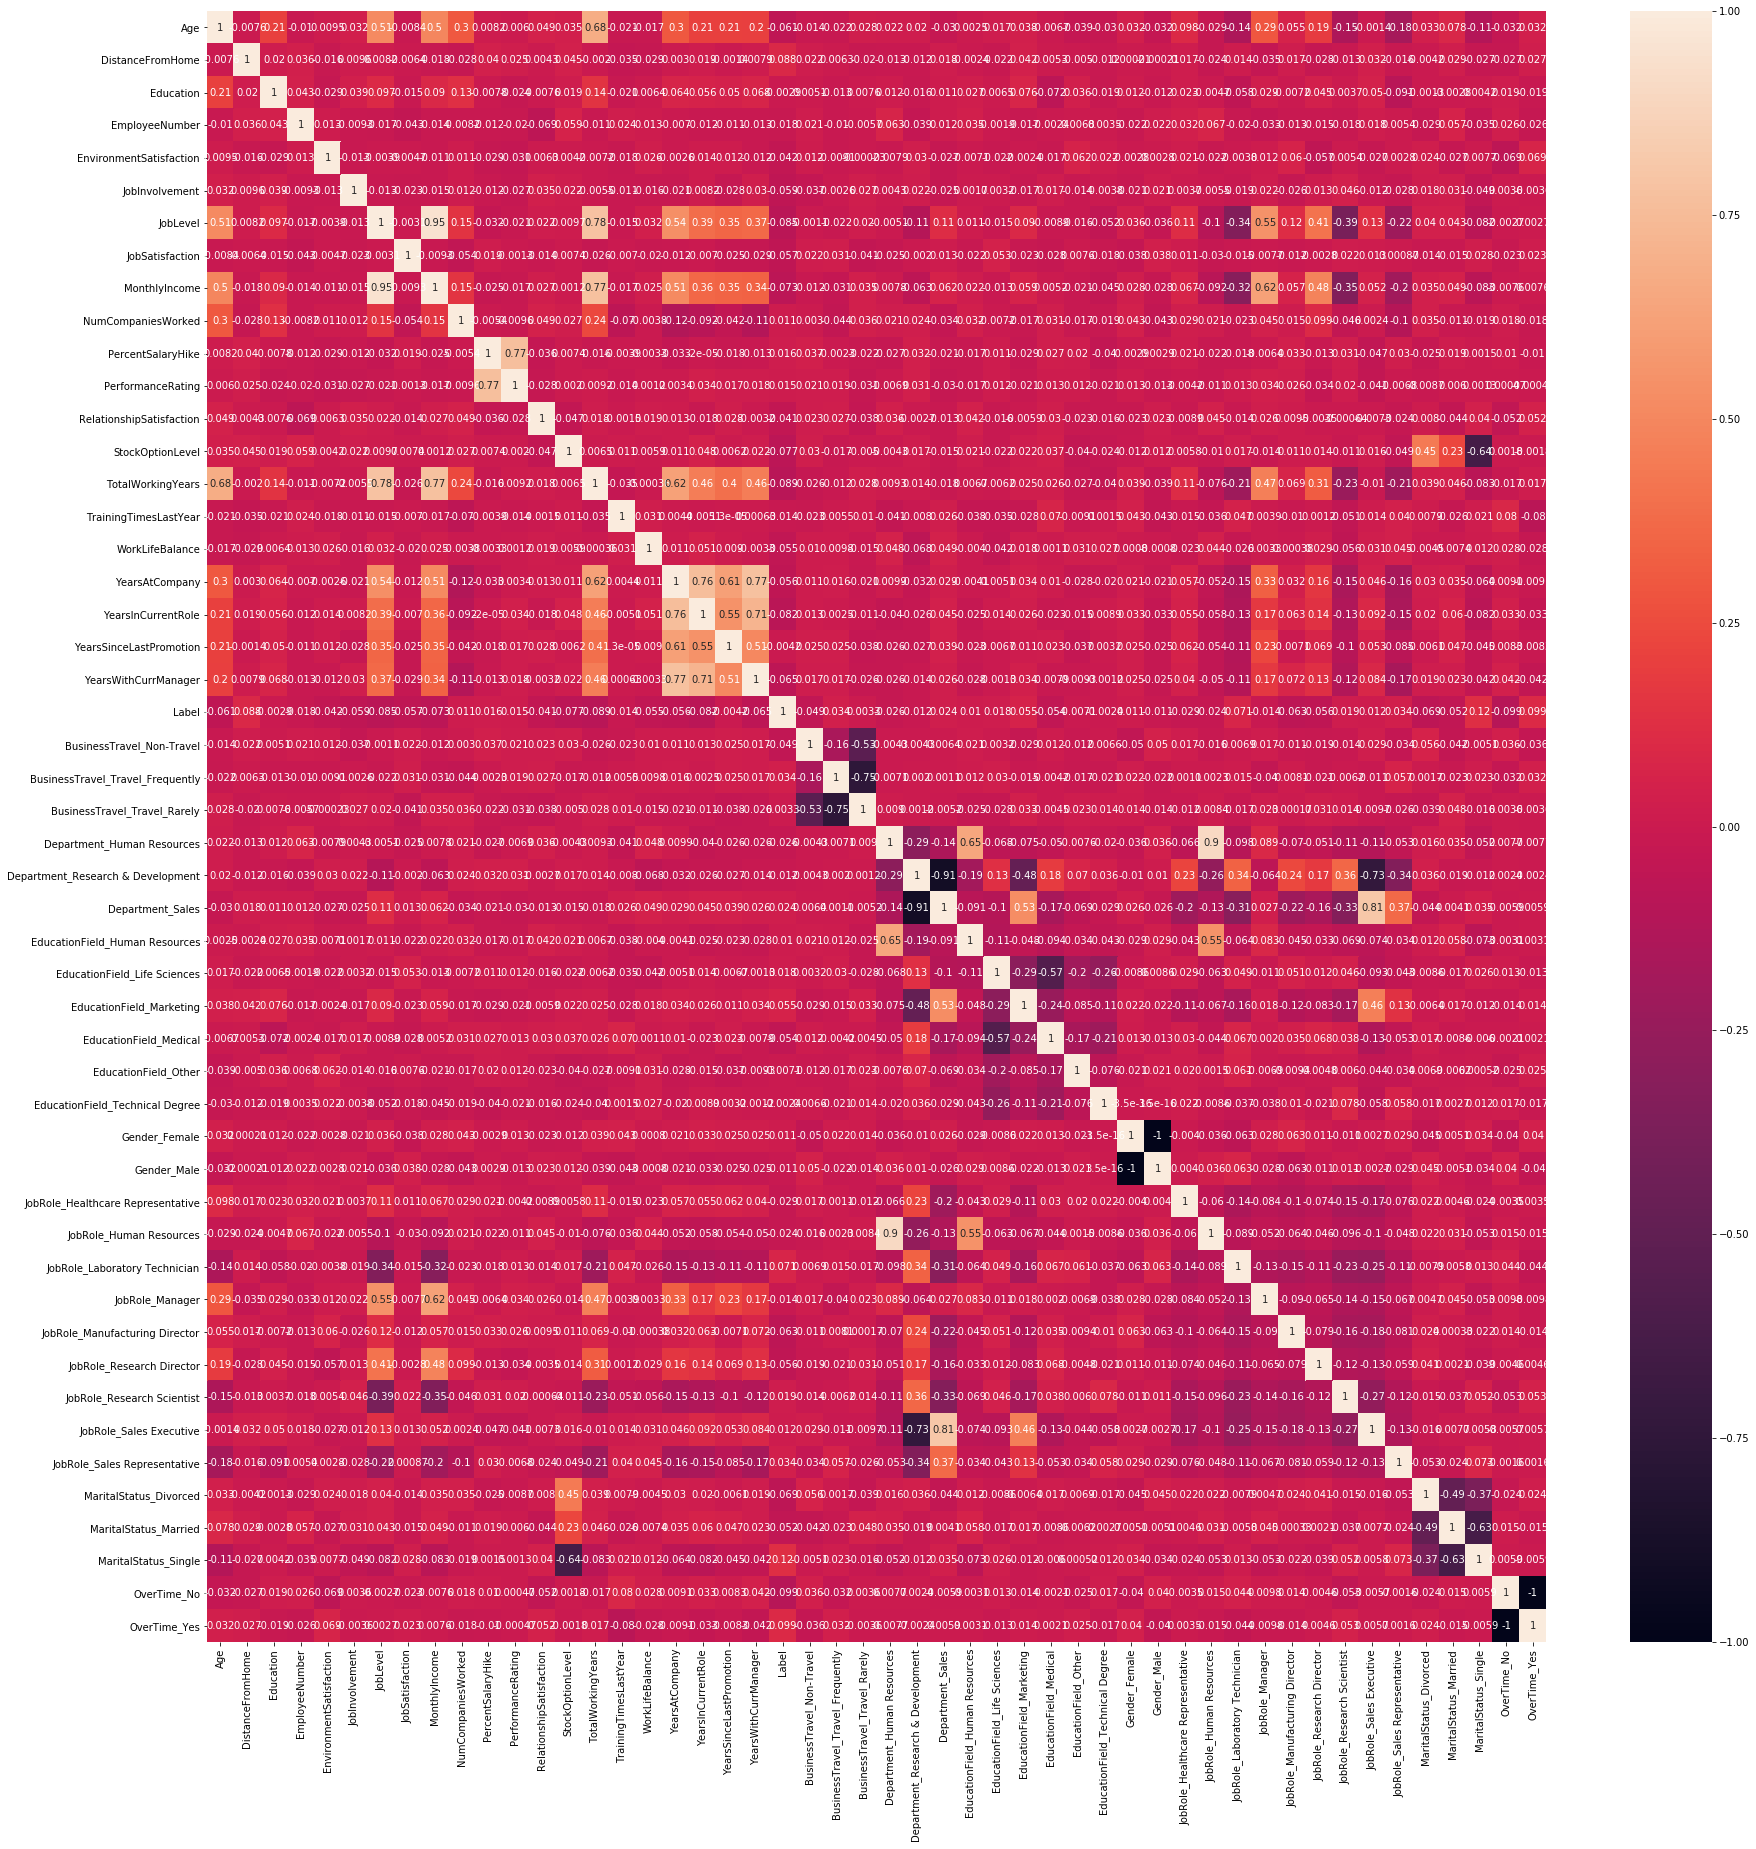

In [12]:
plt.figure(figsize=(30,30))
sns.heatmap(data_merge.drop(['ID'], axis=1).corr(), annot=True)

In [13]:
sub = data_merge[data_merge['Label'] == -1]['ID'].to_frame()
x_train = data_merge[data_merge['Label'] != -1].drop(['ID', 'Label'], axis=1)
y_train = data_merge[data_merge['Label'] != -1]['Label']
x_sub = data_merge[data_merge['Label'] == -1].drop(['ID', 'Label'], axis=1)

## LR

In [14]:
lr = LogisticRegression(C=0.05)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_train)
print(roc_auc_score(y_pred, y_train))

0.8957376663134345


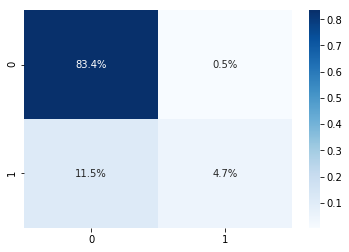

In [16]:
cf_matrix = confusion_matrix(y_train, y_pred)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.1%', cmap='Blues')

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_merge[num_cols] = scaler.fit_transform(data_merge[num_cols])

In [18]:
data_merge

,ID,Age,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0.000000,0.452381,0.000000,0.75,0.036768,0.000000,0.333333,0.25,0.666667,0.262454,...,1,0,0,0,0,1,0,0,1,0
1,0.000690,0.857143,0.000000,0.75,0.601838,1.000000,0.666667,0.50,0.666667,0.499895,...,1,0,0,0,0,1,0,0,1,0
2,0.001380,0.380952,0.214286,0.50,0.070634,0.000000,0.000000,0.25,0.666667,0.266719,...,0,0,0,0,0,0,0,1,0,1
3,0.002070,0.500000,0.000000,0.00,0.495888,1.000000,0.333333,0.75,1.000000,0.617852,...,1,0,0,0,0,0,1,0,1,0
4,0.002761,0.238095,0.000000,0.50,0.537010,0.000000,0.333333,0.00,0.333333,0.083570,...,0,0,0,0,0,1,0,0,1,0
5,0.003451,0.142857,0.107143,0.00,0.698597,1.000000,0.666667,0.25,0.666667,0.166035,...,0,0,0,1,0,0,1,0,0,1
6,0.004141,0.261905,0.285714,1.00,0.219642,0.333333,0.333333,0.00,1.000000,0.156609,...,0,0,0,0,0,0,0,1,1,0
7,0.004831,0.428571,0.035714,0.25,0.247702,0.333333,0.333333,0.50,0.666667,0.346867,...,0,0,0,1,0,0,1,0,1,0
8,0.005521,0.357143,0.107143,0.75,0.147073,0.666667,0.333333,0.00,0.333333,0.084939,...,0,0,1,0,0,0,1,0,1,0
9,0.006211,0.380952,0.035714,0.75,0.668602,0.666667,0.666667,0.25,1.000000,0.298999,...,0,0,0,0,0,0,0,1,1,0


In [19]:
from sklearn.model_selection import GridSearchCV

lr2 = LogisticRegression()
clf = GridSearchCV(lr2, param_grid=[{'C': np.arange(0.001, 0.05, 0.001)}], cv=5)
clf.fit(x_train, y_train)
best_model = clf.best_estimator_
print(clf.best_params_)

{'C': 0.042}


In [20]:
sub['Label'] = best_model.predict(x_sub)
sub.to_csv('sub.csv', index=False)

In [21]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_train)
print(recall_score(y_train, y_pred))

0.9101123595505618


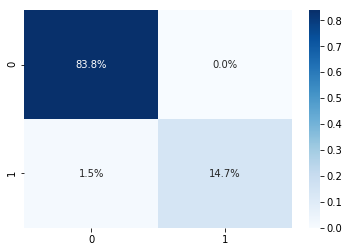

In [22]:
cf_matrix = confusion_matrix(y_train, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.1%', cmap='Blues')

In [23]:
# sub = test_data.ID.to_Frame()
submission = test_data.ID.to_frame()

In [24]:
submission['Label'] = pd.DataFrame(lr.predict(x_sub).tolist()).rename(columns={0: 'Label'})['Label']

In [25]:
feature_importance = pd.DataFrame(list(rfc.feature_importances_), x_train.columns.tolist()).rename(columns={0: 'importance', 'index': 'feature'}).sort_values(by='importance', ascending=False)
selected_features = feature_importance[:20].reset_index()['index'].tolist()
selected_features

['TotalWorkingYears',
 'MonthlyIncome',
 'Age',
 'EmployeeNumber',
 'DistanceFromHome',
 'PercentSalaryHike',
 'OverTime_No',
 'StockOptionLevel',
 'YearsAtCompany',
 'JobSatisfaction',
 'JobInvolvement',
 'NumCompaniesWorked',
 'EnvironmentSatisfaction',
 'RelationshipSatisfaction',
 'WorkLifeBalance',
 'YearsWithCurrManager',
 'OverTime_Yes',
 'YearsInCurrentRole',
 'Education',
 'TrainingTimesLastYear']

## LightGBM

In [26]:
params = {'num_leaves': 60, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'min_data_in_leaf': 30,
          'objective': 'binary', #定义的目标函数
          'max_depth': -1,
          'learning_rate': 0.03,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 0.9,  #提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,             #l1正则
          # 'lambda_l2': 0.001,     #l2正则
          "verbosity": -1,
          "nthread": -1,                #线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'binary_logloss', 'auc'},  ##评价函数选择
          "random_state": 2019, #随机数种子，可以防止每次运行的结果不一致
          # 'device': 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
          }

n_splits = 10
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
sub['Label'] = 0
feature_importances = pd.DataFrame(index=x_train.loc[:, selected_features].columns)

In [27]:
for i, (trn_idx, val_idx) in enumerate(folds.split(x_train, y_train)):
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][selected_features], label=y_train[trn_idx])
    val_data = lgb.Dataset(x_train.iloc[val_idx][selected_features], label=y_train[val_idx])
    
    num_round = 1000
    clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    sub['Label'] += clf.predict(x_sub[selected_features], num_iteration=clf.best_iteration) / n_splits

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.256879	training's auc: 0.931273	valid_1's binary_logloss: 0.365734	valid_1's auc: 0.790323
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.275951	training's auc: 0.921947	valid_1's binary_logloss: 0.361602	valid_1's auc: 0.795102
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.252824	training's auc: 0.941247	valid_1's binary_logloss: 0.387463	valid_1's auc: 0.732378
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.418971	training's auc: 0.858301	valid_1's binary_logloss: 0.433267	valid_1's auc: 0.757766
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.255445	training's auc: 0.940489	valid_1's binary_logloss: 0.35946	valid_1's auc: 0.769928
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.383247	training's auc: 0.878535	valid_1's bina

In [28]:
sub['Label'] = sub['Label'].apply(lambda x: 1 if x>0.5 else 0)

In [29]:
sub.to_csv('sub.csv', index=False)